# Summary

Historical data in this file is from the period 2020-12-20 to 2025-08-31.

Strategies with strong results:
  - Strategy 1: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, fixed correlation in test period to calculate weights
  - Strategy 2: Like strategy 1 except with correlation based on prices

All strategies:
  - Strategy 1: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, fixed correlation in test period to calculate weights
  - Strategy 2: Like strategy 1 except with correlation based on prices
  - Strategy 3: Rolling correlation of returns based on last N periods, dynamically selected at each time step
  - Strategy 4: Rolling correlation of prices based on last N periods, dynamically selected at each time step
  - Strategy 5: Correlation to one asset based on returns, one period behind, trained up to 2024-01-01, correlation for only assets with correlation above threshold x
  - Strategy 6: Correlation to one asset based on prices, one period behind, trained up to 2024-01-01, correlation for only assets with correlation above threshold x
  - Strategy 7: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, dynamic trailing correlation in test period to calculate weights
  - Strategy 8: Same as strategy 1 but winsorized
  - Strategy 9: Same as strategy 1 but truncated
  - Strategy 10: Same as strategy 1 but rank-threshold
  - Strategy 11: Same as strategy 1 but inverse CDF: rank, inverse CDF, then demean-normalize
  - Strategy 12: Strategy 1 with exponential decay
  - Strategy 13: Strategy 1 with average over running period

# Imports

In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np

from ipynb.fs.full.utility_functions import (
    get_rank_demeaned_normalized_signal,
    get_gross_returns_and_net_returns,
    calculate_correlation_directly,
    calculate_covariance_directly,
    get_decorrelated_returns,
    get_strategy_stats,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')


def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Utility Functions

In [4]:
# time_point must be in the index of df
def get_train_test_data(df, time_point):
    train_data = df.loc[:time_point].iloc[:-1]
    test_data = df.loc[time_point:]
    return train_data, test_data


# compared_coin_data = coin_data.shift()
def get_coins_to_top_corr_coins(coin_data, compared_coin_data):
    coins_to_top_corr_coins = dict()
    for col in coin_data.columns:
        corr_with_coin = compared_coin_data.apply(lambda coin_col: calculate_correlation_directly(coin_col, coin_data[col]))
        
        sorted_corr_with_coin = corr_with_coin.sort_values()
        non_coin_corr = sorted_corr_with_coin[sorted_corr_with_coin.index != col]
        
        coins_not_ending_null = non_coin_corr[coin_data.iloc[-10:].notna().any()]
        coins_to_top_corr_coins[col] = coins_not_ending_null[coins_not_ending_null.abs() >= coins_not_ending_null.abs().max()].index[0]
    return coins_to_top_corr_coins


def get_coins_to_look_back_reg_params(train_data, coins_to_top_corr_coins):
    coins_to_look_back_reg_params = dict()
    
    for coin in train_data.columns:
        corr_coin = coins_to_top_corr_coins[coin]

        beta = calculate_covariance_directly(
            train_data[coin], train_data[corr_coin].shift()) / train_data[corr_coin].shift().var()

        val_input = train_data[corr_coin].shift().notna()
        val_output = train_data[coin].notna()

        inputs = train_data[corr_coin].shift()[val_input & val_output]
        outputs = train_data[coin][val_input & val_output]

        alpha = outputs.mean() - beta * inputs.mean()
        coins_to_look_back_reg_params[coin] = {"alpha": alpha, "beta": beta}
    
    return coins_to_look_back_reg_params

# Strategy 1: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, fixed correlation in test period to calculate weights

## Calculate Signal

In [5]:
ret = px / px.shift() - 1
t = datetime(2024, 1, 1, 0, 0)
ret_train_data, ret_test_data = get_train_test_data(ret, t)

coins_to_top_corr_coins_by_ret = get_coins_to_top_corr_coins(ret_train_data, ret_train_data.shift())

coin_rets_to_look_back_reg_params = get_coins_to_look_back_reg_params(
    ret_train_data, coins_to_top_corr_coins_by_ret)

In [6]:
raw_reg_signal = pd.DataFrame(index=ret_test_data.index)
raw_reg_signal.index.names = ['Periods']

for coin in ret_test_data.columns:
    reg_ret = ret_test_data[coins_to_top_corr_coins_by_ret[coin]].shift() * coin_rets_to_look_back_reg_params[coin]['beta']
    reg_ret = reg_ret + coin_rets_to_look_back_reg_params[coin]['alpha']
    
    raw_reg_signal[coin] = -1 * (ret_test_data[coin] - reg_ret)

normalized_signal = get_rank_demeaned_normalized_signal(raw_reg_signal)

## Calculate Returns

In [7]:
test_px = px.loc[normalized_signal.index]
gross_returns, net_returns = get_gross_returns_and_net_returns(normalized_signal, test_px)

<Axes: title={'center': 'Strat 1, Cumulative Gross Returns'}, xlabel='Periods'>

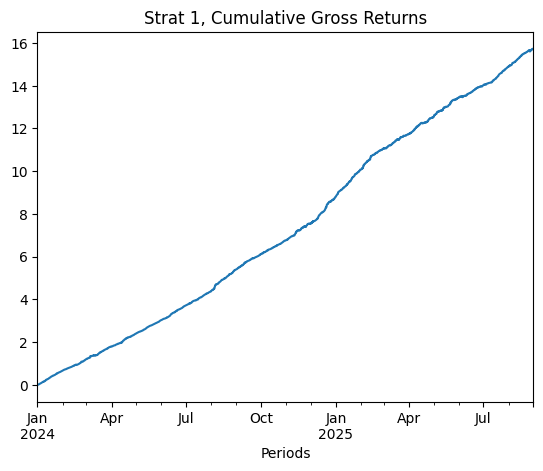

In [8]:
gross_returns.cumsum().plot(title="Strat 1, Cumulative Gross Returns")

In [9]:
pd.Series(get_strategy_stats(net_returns, 4, test_px), name="Strat 1").to_frame()

,Strat 1
avg returns,3.142919
decorrelated avg returns,3.126304
volatility,0.300609
sharpe ratio,10.455168
decorrelated sharpe ratio,10.407555
max drawdown,-2.171735
max drawdown duration,20.500000
alpha_BTC,0.001428
beta_BTC,0.025543


<Axes: title={'center': 'Strat 1, Benchmark, De-Correlated Strat 1, Cumulative Net Returns'}, xlabel='Periods'>

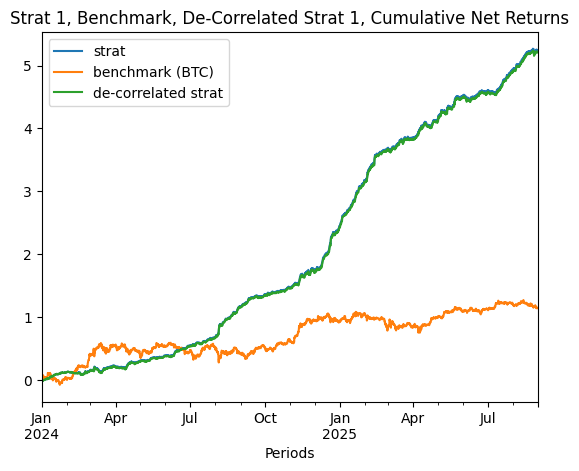

In [10]:
test_btc_rets = test_px['BTCUSDT'] / test_px['BTCUSDT'].shift() - 1

df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": test_btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, test_btc_rets)
})

df.cumsum().plot(title = "Strat 1, Benchmark, De-Correlated Strat 1, Cumulative Net Returns")

The strategy and the de-correlated strategy are effectively the same and the path of the green line covers that of the blue one. This strategy is sufficiently de-correlated from the movement of BTC to be essentially unaffected by it.

# Strategy 2: Like strategy 1 except with correlation based on prices

## Calculate Signal

In [11]:
t = datetime(2024, 1, 1, 0, 0)
px_train_data, px_test_data = get_train_test_data(px, t)

coins_to_top_corr_coins_by_px = get_coins_to_top_corr_coins(px_train_data, px_train_data.shift())

coin_px_to_look_back_reg_params = get_coins_to_look_back_reg_params(
    px_train_data, coins_to_top_corr_coins_by_px)

In [12]:
raw_reg_signal = pd.DataFrame(index=px_test_data.index)
raw_reg_signal.index.names = ['Periods']

for coin in px_test_data.columns:
    reg_px = px_test_data[coins_to_top_corr_coins_by_px[coin]].shift() * coin_px_to_look_back_reg_params[coin]['beta']
    reg_px = reg_px + coin_px_to_look_back_reg_params[coin]['alpha']
    
    raw_reg_signal[coin] = -1 * (px_test_data[coin] - reg_px)

normalized_signal = get_rank_demeaned_normalized_signal(raw_reg_signal)

## Calculate Returns

In [13]:
test_px = px.loc[normalized_signal.index]
gross_returns, net_returns = get_gross_returns_and_net_returns(normalized_signal, test_px)

<Axes: title={'center': 'Strat 2, Cumulative Gross Returns'}, xlabel='Periods'>

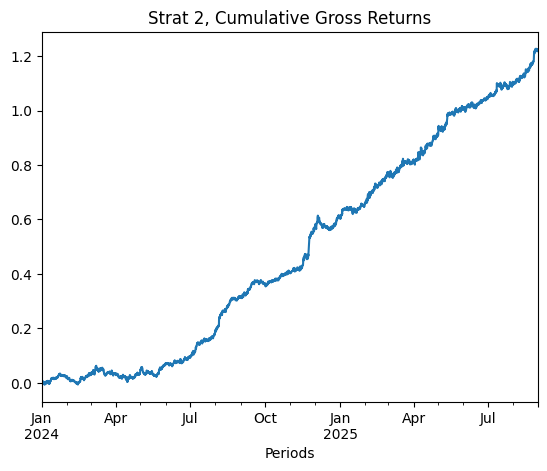

In [14]:
gross_returns.cumsum().plot(title="Strat 2, Cumulative Gross Returns")

In [15]:
pd.Series(get_strategy_stats(net_returns, 4, test_px), name="Strat 2").to_frame()

,Strat 2
avg returns,0.518631
decorrelated avg returns,0.563801
volatility,0.164364
sharpe ratio,3.155378
decorrelated sharpe ratio,3.497602
max drawdown,-13.975127
max drawdown duration,167.833333
alpha_BTC,0.000258
beta_BTC,-0.065709


<Axes: title={'center': 'Strat 2, Benchmark, De-Correlated Strat 2, Cumulative Net Returns'}, xlabel='Periods'>

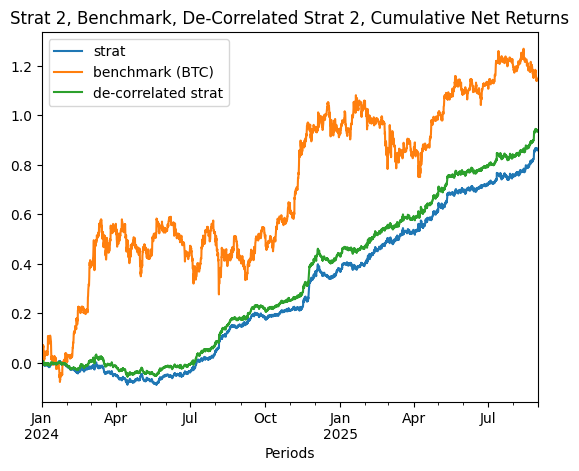

In [16]:
df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": test_btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, test_btc_rets)
})

df.cumsum().plot(title = "Strat 2, Benchmark, De-Correlated Strat 2, Cumulative Net Returns")

# Strategy 3: Rolling correlation of returns based on last N periods, dynamically selected at each time step

In [21]:
ret = px / px.shift() - 1
ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20 04:00:00,0.010716,0.013315,0.021739,0.020863,0.017069,NaN,NaN,0.033748,0.084668,NaN,...,NaN,0.004230,NaN,NaN,NaN,-0.006019,NaN,0.014607,NaN,NaN
2020-12-20 08:00:00,-0.002319,-0.003587,-0.010518,0.034671,0.000553,NaN,NaN,-0.026463,0.028529,NaN,...,NaN,0.010738,NaN,NaN,NaN,0.000000,NaN,0.007803,NaN,NaN
2020-12-20 12:00:00,0.014070,0.000551,0.004799,0.005433,-0.002589,NaN,NaN,0.008553,0.032914,NaN,...,NaN,-0.013320,NaN,NaN,NaN,0.022608,NaN,0.019803,NaN,NaN
2020-12-20 16:00:00,0.002172,-0.005235,-0.002418,-0.008791,-0.008512,NaN,NaN,-0.020991,-0.011406,NaN,...,NaN,-0.005466,NaN,NaN,NaN,-0.011844,NaN,-0.027506,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,0.000563,-0.005439,-0.003769,-0.002863,-0.000178,0.007924,NaN,-0.003526,-0.005505,-0.002136,...,-0.069320,0.000000,0.003623,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000
2025-08-30 20:00:00,-0.003231,0.005161,0.002685,0.006840,0.004346,-0.011268,NaN,0.004899,0.020111,0.004709,...,0.000000,0.000000,-0.087846,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.000000
2025-08-31 00:00:00,0.005397,0.025655,0.017281,0.001009,0.011492,0.024914,NaN,0.008125,-0.002894,0.018321,...,0.053793,0.000000,0.003298,0.022676,0.0,0.000000,0.037928,NaN,NaN,0.056136


In [29]:
shifted_back_returns = ret.shift(1)

ret.iloc[50], shifted_back_returns.iloc[50]

window_len = 20

index = 50

ret_look_back = ret.iloc[(max(index-window_len, 0)):index]
shift_ret_look_back = shifted_back_returns.iloc[(max(index-window_len, 0)):index]

coins_to_best_corr

for col in ret_look_back.columns:
    if ret_look_back[col].isna().any():
        continue
    
    max_abs_corr = 0.0
    max_witness = None
        
    for shift_col in shift_ret_look_back.columns:
        if col == shift_col:
            continue
        if shift_ret_look_back[shift_col].isna().any():
            continue
        abs_corr = abs(calculate_correlation_directly(ret_look_back[col], shift_ret_look_back[shift_col]))
        if abs_corr > max_abs_corr:
            max_abs_corr = abs_corr
            max_witness = shift_col
    
    if max_witness is not None:
        

BTCUSDT    False
ETHUSDT    False
ADAUSDT    False
BNBUSDT    False
XRPUSDT    False
           ...  
OXTUSDT    False
CRVUSDT     True
HNTUSDT    False
BALUSDT     True
CHZUSDT     True
Length: 73, dtype: bool